In [1]:
## Further  recommendation, test multiple frameworks, see what works better on average. 
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
## Save future files to your drive
## In this notebook control for multiple testing
!pip install yfinance --upgrade --no-cache-dir
import numpy as np

Requirement already up-to-date: yfinance in d:\programas\anaconda3\lib\site-packages (0.1.45)


In [13]:
from pandas_datareader import data as pdr
import yfinance  as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("B3SA3.SA", start="2016-01-01").reset_index()
df_full.to_csv('output/B3SA3.csv',index=False)
df_full.head()


[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,10.73,10.95,10.43,10.45,9.50,11394700
1,2016-01-05,10.50,10.91,10.50,10.85,9.86,10840900
2,2016-01-06,10.76,10.96,10.65,10.84,9.85,7183200
3,2016-01-07,10.75,10.77,10.32,10.39,9.44,14588500
4,2016-01-08,10.49,10.60,10.44,10.52,9.56,9129900


In [14]:
df_full = pd.read_csv('output/B3SA3.csv')

In [15]:
 np.__version__

'1.17.1'

# Turtle Trading Agent

In [16]:
df= df_full.copy()
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,10.45,NaN,NaN
1,0.0,10.85,NaN,NaN
2,0.0,10.84,NaN,NaN
3,0.0,10.39,NaN,NaN
4,0.0,10.52,NaN,NaN
...,...,...,...,...
911,0.0,43.00,45.86,31.1
912,0.0,43.63,45.86,31.1
913,0.0,44.29,45.86,31.1
914,0.0,44.80,45.86,31.7


In [17]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [18]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 128: cannot sell anything, inventory 0
day 129: cannot sell anything, inventory 0
day 130: cannot sell anything, inventory 0
day 131: cannot sell anything, inventory 0
day 132: cannot sell anything, inventory 0
day 133: cannot sell anything, inventory 0
day 134: cannot sell anything, inventory 0
day 222: buy 1 units at price 16.300000, total balance 9983.700000
day 228: buy 1 units at price 15.720000, total balance 9967.980000
day 230: buy 1 units at price 15.640000, total balance 9952.340000
day 235: buy 1 units at price 15.470000, total balance 9936.870000
day 237: buy 1 units at price 15.200000, total balance 9921.670000
day 238: buy 1 units at price 15.000000, total balance 9906.670000
day 275, sell 1 units at price 18.840000, investment 25.600000 %, total balance 9925.510000,
day 278, sell 1 units at price 18.900000, investment 26.000000 %, total balance 9944.410000,
day 280, sell 1 units at price 19.560000, investment 30.400000 %, total balance 9963.970000,
day 281, sell 1 un

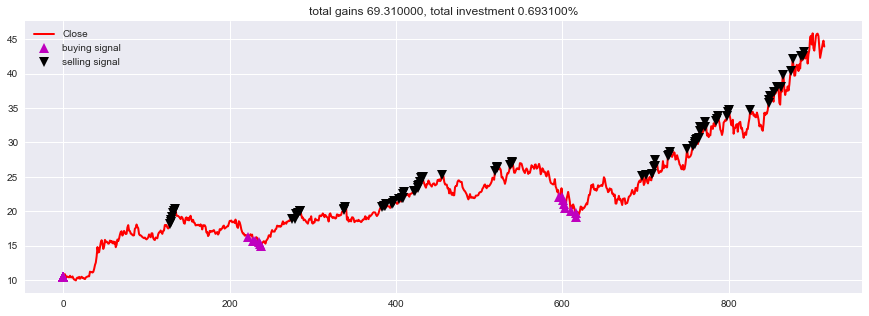

In [19]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()
